In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
with open("./experiments/VDss_Liu2022/IVIT/QR/fold_0/CQR_tmp.pkl", "rb") as fp:
    tmp = pickle.load(fp)

In [3]:
quantiles = tmp["quantiles"]
y_preds_val = tmp["y_preds_val"]
y_latns_val = tmp["y_latns_val"]
y_true_val = tmp["y_true_val"]
y_preds_test = tmp["y_preds_test"]
y_latns_test = tmp["y_latns_test"]
y_true_test = tmp["y_true_test"]

In [4]:
n_test = y_true_test.shape[0]

In [34]:
y_pis_test = y_preds_test[:, [1, -2]]

In [35]:
x = np.arange(n_test)
idx = np.argsort(y_true_test, axis=0)
y_true_test_sorted = np.take_along_axis(y_true_test, idx, axis=0)
y_pis_test_sorted = np.take_along_axis(y_pis_test, idx, axis=0)

In [36]:
y_pis_test_sorted

array([[-1.812075  , -0.33870664],
       [-1.6946696 , -0.7384956 ],
       [-1.5303066 , -0.06695057],
       [-1.6972368 , -0.24232602],
       [-1.5746874 ,  0.13196023],
       [-1.6806129 , -0.2061213 ],
       [-1.5655712 , -0.7070032 ],
       [-1.6656357 , -0.06119005],
       [-1.7073883 , -0.05493537],
       [-1.7376336 , -0.08774981],
       [-1.1580191 ,  0.66873026],
       [-1.7147737 , -0.6762233 ],
       [-1.4350834 ,  0.12215517],
       [-1.7199385 , -0.58161485],
       [-1.2313718 ,  0.32158995],
       [-1.7477801 , -0.15052825],
       [-1.8634142 , -0.38348782],
       [-1.7216628 , -0.76521325],
       [-0.8954454 ,  1.0289773 ],
       [-1.3136193 ,  0.37483642],
       [-1.7125264 , -0.79192924],
       [-1.4207851 ,  0.31097323],
       [-1.499872  , -0.56593806],
       [-1.4497213 ,  0.28912508],
       [-1.408889  , -0.1085622 ],
       [-1.5866836 , -0.47768018],
       [-1.528835  , -0.7130141 ],
       [-1.602935  , -0.6004617 ],
       [-1.731919  ,

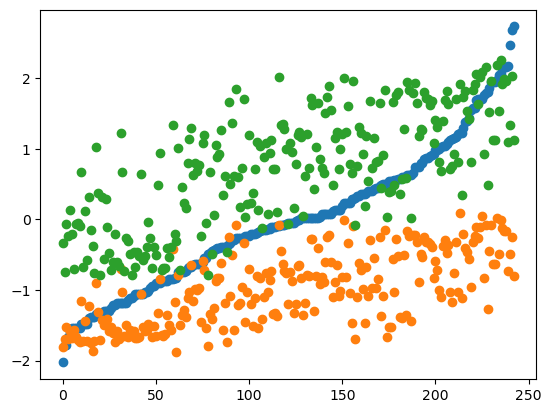

In [37]:
plt.scatter(x=x, y=y_true_test_sorted, label="True value")
plt.scatter(x, y_pis_test_sorted[:, 0], label='Q10')
plt.scatter(x, y_pis_test_sorted[:, 1], label='Q90')

In [31]:
y_pis_val = y_preds_val[:, [0, -1]]
y_pis_test = y_preds_test[:, [0, -1]]

In [32]:
def evaluate_icp(pred, Y):
    # Extract lower and upper prediction bands
    pred_l = np.min(pred,1)
    pred_h = np.max(pred,1)
    # Marginal coverage
    cover = (Y>=pred_l)*(Y<=pred_h)
    marg_coverage = np.mean(cover)
    # if X is None:
    #     wsc_coverage = None
    # else:
    #     # Estimated conditional coverage (worse-case slab)
    #     wsc_coverage = coverage.wsc_unbiased(X, Y, pred, M=100)

    # Marginal length
    lengths = pred_h-pred_l
    length = np.mean(lengths)
    # Length conditional on coverage
    idx_cover = np.where(cover)[0]
    length_cover = np.mean([lengths for i in idx_cover])

    # Combine results
    out = pd.DataFrame({'Coverage': [marg_coverage], 'Length': [length], 'Length cover': [length_cover]})
    return out

In [33]:
evaluate_icp(y_pis_test, y_true_test)

,Coverage,Length,Length cover
0,0.639537,2.252297,2.252298


In [34]:
evaluate_icp(y_pis_val, y_true_val)

,Coverage,Length,Length cover
0,0.654423,2.297125,2.297125


In [35]:
from chempropv2.utils import find_nearest

# CQR error function
class CQR_errfun:
    """Calculates conformalized quantile regression error.
    Conformity scores:
    .. math::
    max{\hat{q}_low - y, y - \hat{q}_high}
    """

    def __init__(self):
        super(CQR_errfun, self).__init__()

    def apply(self, prediction, y):
        y_lower = prediction[:, 0]
        y_upper = prediction[:, -1]
        error_low = y_lower - y
        error_high = y - y_upper
        err = np.maximum(error_high, error_low)
        return err

    def apply_inverse(self, nc, alpha):
        q = np.quantile(
            nc, np.minimum(1.0, (1.0 - alpha) * (nc.shape[0] + 1.0) / nc.shape[0])
        )
        return np.vstack([q, q])


def run_cqr(y_true_calib, y_preds_calib, y_pred_test, quantiles, alpha: float = 0.1):
    # extract indexes of lower and upper 
    idx_lower = find_nearest(quantiles, alpha / 2.0)
    idx_upper = find_nearest(quantiles, 1.0 - alpha / 2.0)
    # extract prediction intervals of calibration set
    y_pis_calib = y_preds_calib[:, [idx_lower, idx_upper]]
    scorer = CQR_errfun()
    scores = scorer.apply(y_pis_calib, y_true_calib)
    score_correction = scorer.apply_inverse(scores, alpha)
    y_pis_test = y_pred_test[:, [idx_lower, idx_upper]]
    y_pis_test[:, 0] -= score_correction[0, 0]
    y_pis_test[:, 1] += score_correction[1, 0]
    return y_pis_test

In [38]:
y_conf_test = run_cqr(y_true_val, y_preds_val, y_preds_test, quantiles)

In [39]:
evaluate_icp(y_conf_test, y_true_test)

,Coverage,Length,Length cover
0,0.890904,3.837135,3.837135


In [40]:
import math
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

In [47]:
class SparseGPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SparseGPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.base_covar_module = ScaleKernel(RBFKernel())
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.covar_module = InducingPointKernel(self.base_covar_module, 
                                                inducing_points=train_x[:100, :].clone(), 
                                                likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [92]:
y_latns_val = torch.from_numpy(y_latns_val)
y_true_val = torch.from_numpy(y_true_val)
y_latns_test = torch.from_numpy(y_latns_test)
y_true_val = torch.from_numpy(y_true_val)

TypeError: expected np.ndarray (got Tensor)

In [97]:
y_true_test = torch.from_numpy(y_true_test).squeeze().cuda()

TypeError: expected np.ndarray (got Tensor)

In [98]:
y_true_test = y_true_test.type(torch.cuda.FloatTensor)

In [69]:
y_latns_val.shape

torch.Size([243, 300])

In [70]:
y_true_val.shape

torch.Size([243, 1])

In [71]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SparseGPRegressionModel(y_latns_val, y_true_val, likelihood)

In [72]:
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [73]:
training_iterations = 100

In [74]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [81]:
y_true_val = y_true_val.squeeze()

In [82]:
y_true_val.shape

torch.Size([243])

In [90]:
y_true_val = y_true_val.type(torch.cuda.FloatTensor)
y_true_test = y_true_test.type(torch.cuda.FloatTensor)

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [89]:
iterator = tqdm.tqdm(range(training_iterations), desc="Train")

for i in iterator:
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(y_latns_val)
    # Calc loss and backprop derivatives
    loss = -mll(output, y_true_val)
    loss.backward()
    iterator.set_postfix(loss=loss.item())
    optimizer.step()
    torch.cuda.empty_cache()

Train:   0%|          | 0/100 [00:00<?, ?it/s]

In [101]:
model.eval()
likelihood.eval()
with torch.no_grad():
    preds = model.likelihood(model(y_true_test))

RuntimeError: Flattening the training labels failed. The most common cause of this error is that the shapes of the prior mean and the training labels are mismatched. The shape of the train targets is torch.Size([243, 1]), while the reported shape of the mean is torch.Size([243]).

In [100]:
preds.mean

NameError: name 'preds' is not defined

In [78]:
import urllib.request
import os
from scipy.io import loadmat
from math import floor


# this is for running the notebook in our testing framework
smoke_test = False


if not smoke_test and not os.path.isfile('./elevators.mat'):
    print('Downloading \'elevators\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1jhWL3YUHvXIaftia4qeAyDwVxo6j1alk', '../elevators.mat')


if smoke_test:  # this is for running the notebook in our testing framework
    X, y = torch.randn(1000, 3), torch.randn(1000)
else:
    data = torch.Tensor(loadmat('../elevators.mat')['data'])
    X = data[:, :-1]
    X = X - X.min(0)[0]
    X = 2 * (X / X.max(0)[0]) - 1
    y = data[:, -1]


train_n = int(floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

ValueError: Unknown mat file type, version 108, 59